This notebook was maintained by Tanvi Sivaraj

In [3]:
# pip install spacy

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import spacy
import re
import seaborn as sns
sns.set_style('whitegrid')

In [18]:
# run if needed: spacy OSError
# !python -m spacy download en_core_web_sm

In [19]:
df = pd.read_csv(r'..\..\data\processed\AnimeData_300724_processed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26794 entries, 0 to 26793
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         26794 non-null  object 
 1   episodes      14396 non-null  float64
 2   release_year  26794 non-null  int64  
 3   status        26389 non-null  object 
 4   genres        20119 non-null  object 
 5   studio        25663 non-null  object 
 6   source        23896 non-null  object 
 7   demographic   10142 non-null  object 
 8   synopsis      26785 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ MB


In [20]:
df.head()

,title,episodes,release_year,status,genres,studio,source,demographic,synopsis
0,Shingeki no Kyojin,25.0,2013,Finished,"Action, Award Winning, Drama, Suspense",Wit Studio,Manga,Shounen,centuries ago mankind was slaughtered to near ...
1,Fullmetal Alchemist: Brotherhood,64.0,2009,Finished,"Action, Adventure, Drama, Fantasy",Bones,Manga,Shounen,after a horrific alchemy experiment goes wrong...
2,One Punch Man,12.0,2015,Finished,"Action, Comedy",Madhouse,Web manga,Seinen,the seemingly unimpressive saitama has a rathe...
3,Sword Art Online,25.0,2012,Finished,"Action, Adventure, Fantasy, Romance",A-1 Pictures,Light novel,NaN,ever since the release of the innovative nerve...
4,Kimetsu no Yaiba,26.0,2019,Finished,"Action, Award Winning, Fantasy",ufotable,Manga,Shounen,ever since the death of his father the burden ...


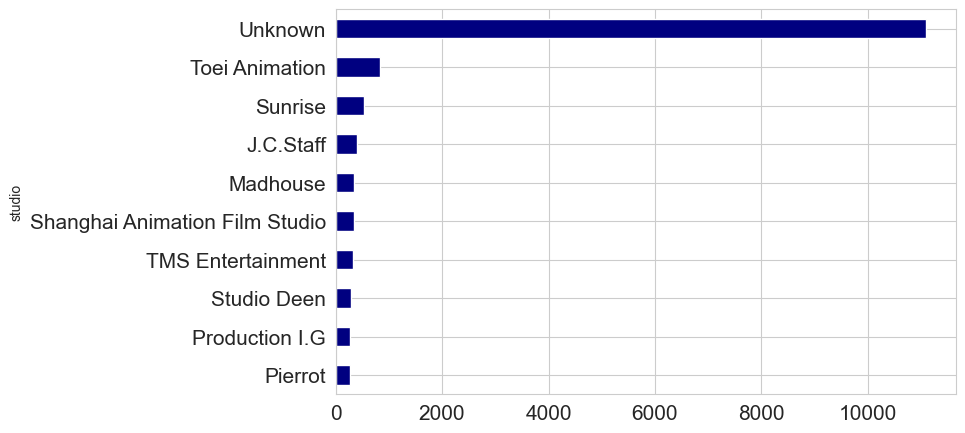

In [21]:
# Count the occurrences of each unique value in the 'studio' column
# Select the top 10 most frequent studios
# Plot these counts as a horizontal bar chart
df['studio'].value_counts().nlargest(10).plot(
    kind='barh',               # Create a horizontal bar chart
    figsize=[8,5],             # Set the figure size to 8x5 inches
    fontsize=15,               # Set the font size of the labels to 15
    color='navy'               # Set the color of the bars to navy
).invert_yaxis()               # Invert the y-axis to have the highest values on top

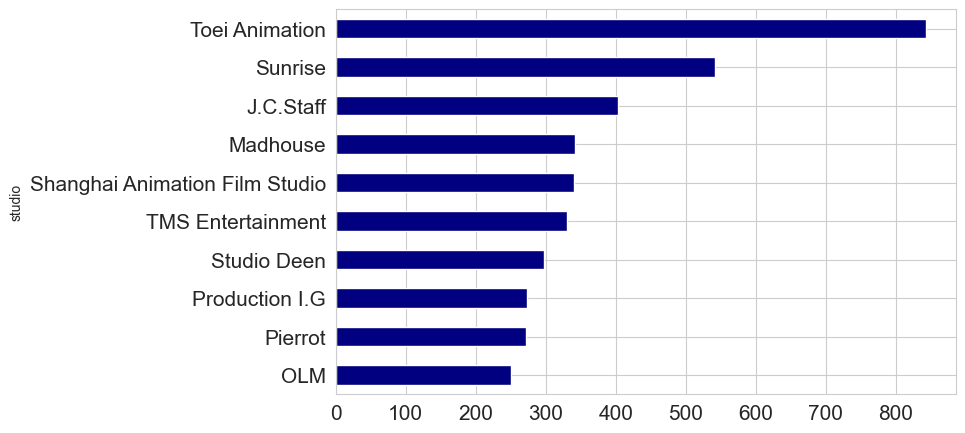

In [22]:
# # Filter out rows where the 'studio' column has the value 'unknown'
# filtered_df = df[(df['studio'] != 'Unknown')]

# Count occurrences of each unique value in the filtered 'studio' column
# Select the top 10 most frequent studios
df['studio'].value_counts()[1:11].plot(
    kind='barh',               # Create a horizontal bar chart
    figsize=[8,5],             # Set the figure size to 8x5 inches
    fontsize=15,               # Set the font size of the labels to 15
    color='navy'               # Set the color of the bars to navy
).invert_yaxis()               # Invert the y-axis to have the highest values on top


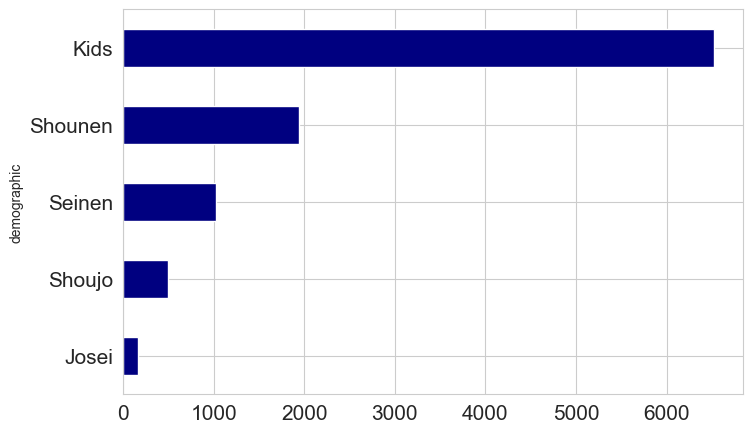

In [23]:
# Count the occurrences of each unique value in the 'Demographic' column
# Select the top 10 most frequent demographics
df['demographic'].value_counts().nlargest(10).plot(
    kind='barh',               # Create a horizontal bar chart
    figsize=[8,5],             # Set the figure size to 8x5 inches
    fontsize=15,               # Set the font size of the labels to 15
    color='navy'               # Set the color of the bars to navy
).invert_yaxis()               # Invert the y-axis to have the highest values on top

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26794 entries, 0 to 26793
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         26794 non-null  object 
 1   episodes      14396 non-null  float64
 2   release_year  26794 non-null  int64  
 3   status        26389 non-null  object 
 4   genres        20119 non-null  object 
 5   studio        25663 non-null  object 
 6   source        23896 non-null  object 
 7   demographic   10142 non-null  object 
 8   synopsis      26785 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ MB


In [25]:
df[df.duplicated(subset=['title'], keep=False)].sort_values(by='title')['synopsis'].to_list()

['through their tutor fuutarou uesugis diligent guidance the nakano quintuplets academic performance shows signs of improvement even if their path to graduation is still rocky however as they continue to cause various situations that delay any actual tutoring fuutarou becomes increasingly involved with their personal lives further complicating their relationship with each other on another note fuutarou slowly begins to realize the existence of a possible connection between him and the past he believes to have shared with one of the five girls with everyones feelings beginning to develop and overlap will they be able to keep their bond strictly to that of a teacher and his studentsor will it mature into something else entirely',
 'featuring stories from the manga not adapted in the main anime',
 'toubun no hanayome centers on the honeymoon trip of fuutarou uesugi and the nakano sisters source mal news',
 'fuutarou uesugi is an ace high school student but leads an otherwise tough life hi

In [26]:
df.shape

(26794, 9)

In [27]:
df.drop_duplicates(subset=['title'], keep='last', inplace=True)
df.shape

(26734, 9)

In [28]:
df.fillna('', inplace=True)

C:\Users\Asif Sayyed\AppData\Local\Temp\ipykernel_20124\1272664119.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


In [29]:
df.reset_index(drop=True, inplace=True)

In [30]:
# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Ensure 'Genres' column is of type string
df['genres'] = df['genres'].astype(str)

# Replace commas in the 'Genres' column with spaces
df['genres'] = df['genres'].str.replace(',', ' ')

def preprocess_text(text):
    """
    Preprocess text by lemmatizing and removing stop words and non-alphabetic tokens.

    Parameters:
    text (str): The text to preprocess.

    Returns:
    str: The preprocessed text.
    """
    # Create a SpaCy document object
    doc = nlp(text)
    
    # Lemmatize tokens, convert to lowercase, and filter out stop words and non-alphabetic tokens
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    
    # Join the tokens into a single string
    return ' '.join(tokens)

# Apply the preprocessing function to the 'Genres' column
df['genres'] = df['genres'].apply(preprocess_text)

# Apply the preprocessing function to the 'Synopsis' column
df['genres'] = df['genres'].apply(preprocess_text)

In [31]:
#Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the textual df
tfidf_matrix = vectorizer.fit_transform(df['genres']+ " " + df['synopsis'])

In [32]:
# Compute the cosine similarity matrix for the TF-IDF matrix
# The similarity matrix is a square matrix where each element [i, j] represents
# the cosine similarity between item i and item j based on their TF-IDF representations.
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [38]:
df

,title,episodes,release_year,status,genres,studio,source,demographic,synopsis
0,Shingeki no Kyojin,25.0,2013,Finished,action award win drama suspense,Wit Studio,Manga,Shounen,centuries ago mankind was slaughtered to near ...
1,Fullmetal Alchemist: Brotherhood,64.0,2009,Finished,action adventure drama fantasy,Bones,Manga,Shounen,after a horrific alchemy experiment goes wrong...
2,One Punch Man,12.0,2015,Finished,action comedy,Madhouse,Web manga,Seinen,the seemingly unimpressive saitama has a rathe...
3,Sword Art Online,25.0,2012,Finished,action adventure fantasy romance,A-1 Pictures,Light novel,,ever since the release of the innovative nerve...
4,Kimetsu no Yaiba,26.0,2019,Finished,action award win fantasy,ufotable,Manga,Shounen,ever since the death of his father the burden ...
...,...,...,...,...,...,...,...,...,...
26729,Money Wars: Nerawareta Waterfront Keikaku,,1991,Finished,,Gainax,Original,Seinen,a new waterfront area is being built in tokyo ...
26730,Otokogi,3.0,1990,Finished,,Unknown,Manga,Seinen,after his father leaves when he is very young ...
26731,Shin Otokogi,2.0,1998,Finished,,Unknown,Manga,Seinen,the sequel to the trilogy otokogi which follow...
26732,Kuro to Kin no Akanai Kagi.,2.0,2013,Finished,,An DerCen,Visual novel,Josei,katagiri kanade is a hikikomori who spent her ...


In [39]:
def get_top_5_recommendations(title_name, df, similarity_matrix):
    """
    Get the top 5 recommended titles based on similarity to a given title.

    Parameters:
    title_name (str): The title for which recommendations are to be made.
    df (pd.DataFrame): DataFrame containing the titles and other information.
    similarity_matrix (np.ndarray): Matrix where each element [i, j] represents the similarity between title i and title j.

    Returns:
    list: A list of the top 5 recommended titles, excluding the input title and ensuring no similar titles are included.
    
    Raises:
    ValueError: If the input title is not found in the DataFrame.
    """
    # Ensure the title exists in the DataFrame
    if title_name not in df['title'].values:
        raise ValueError("Title not found in the DataFrame")

    # Find the index of the input title
    item_index = df[df['title'] == title_name].index[0]

    # Get the list of titles sorted by similarity
    titles = df.iloc[similarity_matrix[item_index].argsort()[::-1]]['title'].to_list()

    # Initialize list to store the top 5 recommendations
    recommendations = []

    # Get the top 5 recommendations
    for title in titles:
        if title_name not in title and title_name != title:
            recommendations.append(title)
        if len(recommendations) == 5:
            break

    return recommendations

In [41]:
# Example usage
# df is your DataFrame
# similarity_matrix is the computed similarity matrix
# title_name is the title you want recommendations for
recommendations = get_top_5_recommendations('One Piece', df, similarity_matrix)
recommendations

['Kaizoku Ouji',
 'Peter Pan no Bouken',
 'Kenran Butou Sai: The Mars Daybreak',
 'Bu Si Bu Mie',
 'Xiyou Ji: Dasheng Guilai']